In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from collections import Counter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [35]:
pwd

'C:\\Users\\mnan\\Desktop\\viz\\house_pred_ML'

In [43]:
def false_na(train):
    train['GarageType']=train['GarageType'].replace({np.nan:'noGarage'})
    train['GarageFinish']=train['GarageFinish'].replace({np.nan:'noGarage'})
    train['GarageQual']=train['GarageQual'].replace({np.nan:'noGarage'})
    train['GarageCars']=train['GarageCars'].replace({np.nan:0})
    train['GarageArea']=train['GarageArea'].replace({np.nan:'0'})
    train['GarageCond']=train['GarageCond'].replace({np.nan:'noGarage'})
    
    train['BsmtExposure']=train['BsmtExposure'].replace({np.nan:'noBasement'})
    train['BsmtFinType2']=train['BsmtFinType2'].replace({np.nan:'noBasement'})
    train['BsmtFinType1']=train['BsmtFinType1'].replace({np.nan:'noBasement'})
    train['BsmtCond']=train['BsmtCond'].replace({np.nan:'noBasement'})
    train['BsmtQual']=train['BsmtQual'].replace({np.nan:'noBasement'})
    train['TotalBsmtSF']=train['TotalBsmtSF'].replace({np.nan:0})
    train['BsmtFinSF1']=train['BsmtFinSF1'].replace({np.nan:0})
    train['BsmtFinSF2']=train['BsmtFinSF2'].replace({np.nan:0})
    train['BsmtUnfSF']=train['BsmtUnfSF'].replace({np.nan:0})
    train['TotalBsmtSF']=train['TotalBsmtSF'].replace({np.nan:0})
    train['BsmtHalfBath']=train['BsmtHalfBath'].replace({np.nan:0})
    train['BsmtFullBath']=train['BsmtFullBath'].replace({np.nan:0})

    train['FireplaceQu']=train['FireplaceQu'].replace({np.nan:'noFireplace'})
    train['MasVnrType']=train['MasVnrType'].replace({np.nan:'noMasonryVeneer'})
    train['MasVnrArea']=train['MasVnrArea'].replace({np.nan:0})  
    train['MSZoning']=train['MSZoning'].replace({np.nan:'RL'})  
    train['Functional']=train['Functional'].replace({np.nan:'Typ'})  
    train['Exterior1st']=train['Exterior1st'].replace({np.nan:'VinylSd'})  
    train['Exterior2nd']=train['Exterior2nd'].replace({np.nan:'VinylSd'})  
    train['Electrical']=train['Electrical'].replace({np.nan:'SBrkr'})  
    train['SaleType']=train['SaleType'].replace({np.nan:'WD'}) 
    train['KitchenQual']=train['KitchenQual'].replace({np.nan:'TA'})  
    
    train['LotFrontage']=train['LotFrontage'].replace({np.nan:train['LotFrontage'].median()}) 
    
    return train

def check_dtype(df):
    for col in df.columns:
        df[col] = df[col].astype('float')
    print("Cols in df are all numerical is %s"%(sum([df[col].dtypes=='float'
                                                     for col in df.columns])==len(df.columns)))
    return df

def rmse_cv(estimator, X, y):
    rmse= np.sqrt(-cross_val_score(estimator, X, y, scoring="neg_mean_squared_error"))
    return(np.mean(rmse))

In [46]:
train = pd.read_csv("data/train.csv",index_col = 0)
test = pd.read_csv("data/test.csv",index_col = 0)

col_drop = list(pd.DataFrame(train.isnull().sum(),columns = ['missingVal'])
                .query('missingVal>0')
                .sort_values(by = 'missingVal',ascending = False)
                .index[:4])
## drop cols
for col in col_drop:
    train = train.drop(col, 1)
    test = test.drop(col,1)
    
train = train.drop('Utilities', 1) ## no data variety in Utilities
test = test.drop('Utilities', 1)
train = train.drop('GarageYrBlt',1) ## 'GarageYrBlt' duplicate with YearBuilt
test = test.drop('GarageYrBlt',1)
print('Now we have %d features'%test.shape[1])


test = false_na(test)
train = false_na(train)

df_dtypes = pd.DataFrame(train.dtypes,columns=['train_dtypes']).join(pd.DataFrame(test.dtypes,columns=['test_dtypes']))
df_dtypes_diff = df_dtypes.ix[df_dtypes['train_dtypes'] != df_dtypes['test_dtypes']]

for col in df_dtypes_diff.index[:6]:
    train[col] = train[col].astype('float')
train['GarageCars'] = train['GarageCars'].astype('float')
test['GarageArea'] = test['GarageArea'].astype('float')
train['GarageArea'] = train['GarageArea'].astype('float')

# check
df_dtypes0 = pd.DataFrame(train.dtypes,columns=['train_dtypes']).join(pd.DataFrame(test.dtypes,columns=['test_dtypes']))
print(df_dtypes0.ix[df_dtypes0['train_dtypes'] != df_dtypes0['test_dtypes']])



df_dtypes = pd.DataFrame(train.dtypes,columns = ['dtypes'])
numeric_cols = df_dtypes[df_dtypes['dtypes']!='object'].index
cate_cols = df_dtypes[df_dtypes['dtypes']=='object'].index

train_dummies = pd.get_dummies(train)
test_dummies = pd.get_dummies(test)
    
train = check_dtype(train_dummies)
test = check_dtype(test_dummies)

#selector = VarianceThreshold(0.8)
#train_reduced = pd.DataFrame(selector.fit_transform(train),columns = train.columns[selector.get_support()])
#test_reduced = pd.DataFrame(selector.fit_transform(test),columns = test.columns[selector.get_support()])


print('Now we only have %d features' % len(test.columns))
#print("Features we remove are %s" % train.columns[~selector.get_support()])

Now we have 73 features
          train_dtypes test_dtypes
SalePrice        int64         NaN
Cols in df are all numerical is True
Cols in df are all numerical is True
Now we only have 268 features


In [61]:
common_cols = []
for col in train.columns:
    if col in test.columns:
        common_cols.append(col)

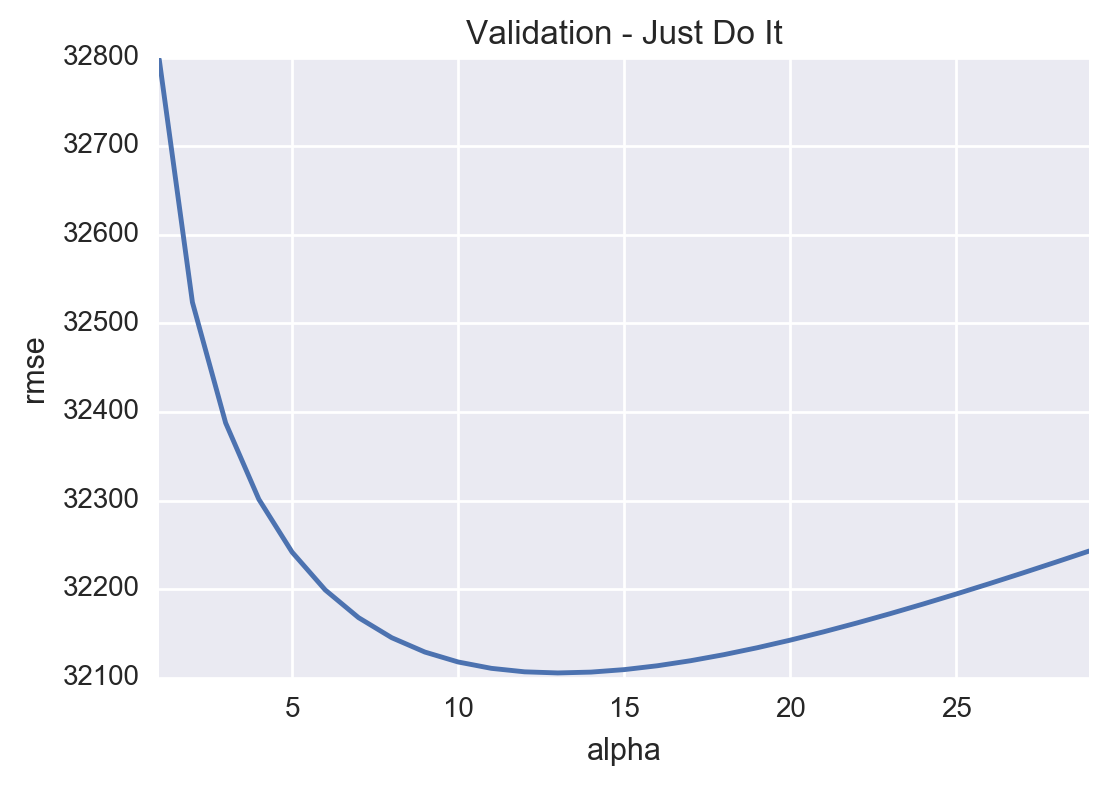

In [69]:
#train["SalePrice"] = np.log1p(train["SalePrice"])
X_train = train[common_cols]
y = train.SalePrice

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
model_ridge = Ridge()
alphas = np.arange(1,30,1)
cv_ridge = [rmse_cv(Ridge(alpha = alpha),X_train,y).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [73]:
cv_ridge.min()

32105.332300647668

In [74]:
cv_ridge

1     32798.142545
2     32523.811873
3     32387.639573
4     32301.386280
5     32241.773938
6     32198.978680
7     32167.805451
8     32145.127257
9     32128.899371
10    32117.706038
11    32110.525119
12    32106.594695
13    32105.332301
14    32106.283437
15    32109.087375
16    32113.453667
17    32119.145560
18    32125.968000
19    32133.758774
20    32142.381863
21    32151.722372
22    32161.682610
23    32172.179019
24    32183.139746
25    32194.502706
26    32206.214019
27    32218.226735
28    32230.499795
29    32242.997173
dtype: float64

In [76]:
model_ridge = Ridge(alpha = 13)
model_ridge.fit(X_train,y)
pd.DataFrame(model_ridge.predict(test)).to_csv('result.csv')

In [54]:
cv_ridge

0.010    6.961605e-09
0.011    6.558975e-09
0.012    8.571804e-09
0.013    5.630112e-09
0.014    3.788544e-09
0.015    6.399941e-09
0.016    4.713578e-09
0.017    5.180302e-09
0.018    4.911313e-09
0.019    5.393706e-09
0.020    4.849573e-09
0.021    3.962929e-09
0.022    3.324197e-09
0.023    4.673621e-09
0.024    4.036741e-09
0.025    5.368161e-09
0.026    4.212869e-09
0.027    4.135052e-09
0.028    4.334830e-09
0.029    4.402729e-09
0.030    4.584065e-09
0.031    4.430505e-09
0.032    4.404443e-09
0.033    4.159387e-09
0.034    3.806543e-09
0.035    4.260618e-09
0.036    4.318846e-09
0.037    4.315589e-09
0.038    4.056385e-09
0.039    4.178475e-09
             ...     
0.071    6.316949e-09
0.072    6.201293e-09
0.073    6.443170e-09
0.074    6.721134e-09
0.075    6.530964e-09
0.076    6.959353e-09
0.077    6.647733e-09
0.078    6.659122e-09
0.079    6.799553e-09
0.080    6.707631e-09
0.081    6.873581e-09
0.082    6.851604e-09
0.083    7.162262e-09
0.084    7.195609e-09
0.085    7

In [25]:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [6]:
X = train_reduced.ix[:,:-1]
y = train_reduced.ix[:,-1]
forest = RandomForestRegressor(n_estimators=100)
scores= cross_val_score(forest,X,y,cv=10,scoring = rmse_cv) 

In [7]:
scores

array([ 0.19683568,  0.17294974,  0.18298359,  0.21937586,  0.20803065,
        0.16710548,  0.17651048,  0.17755962,  0.20193634,  0.19768943])

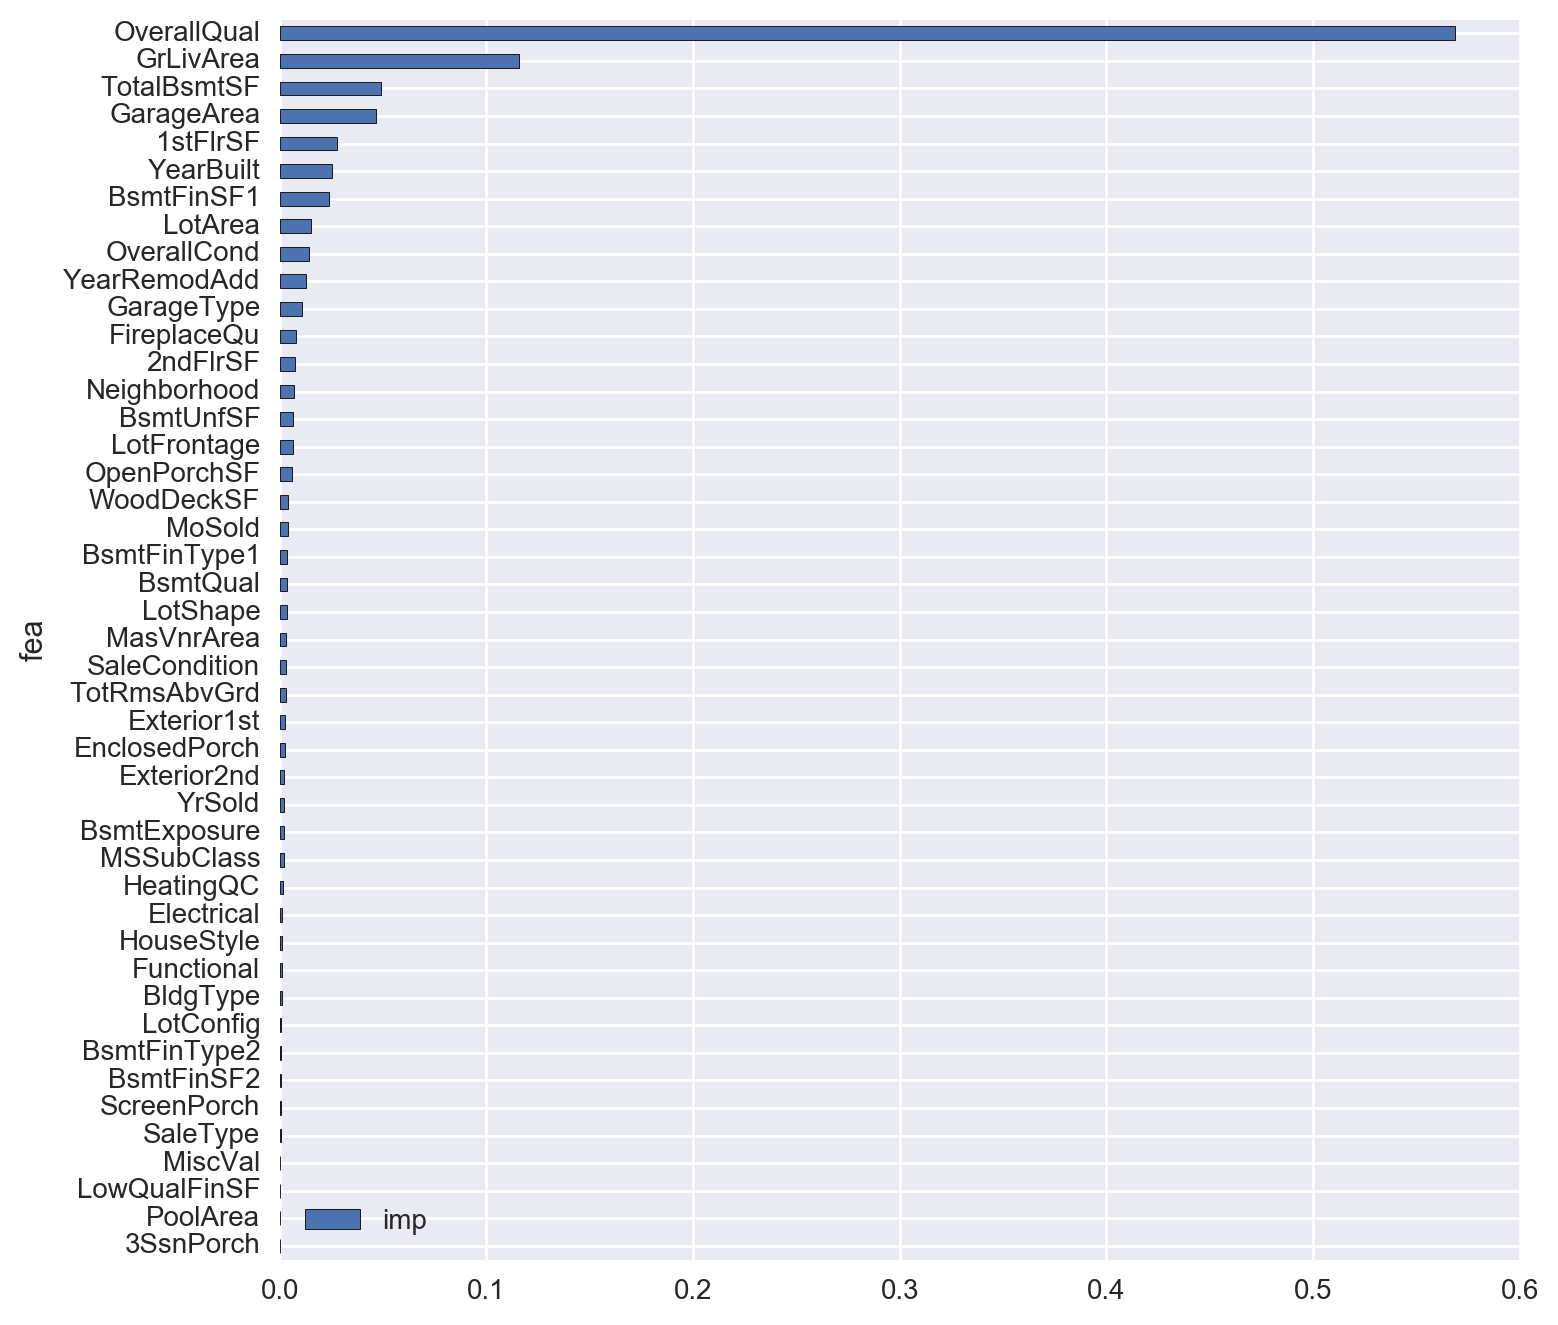

In [ ]:
forest.fit(X,y)
feature_imp = forest.feature_importances_
pd.DataFrame.from_dict({'imp':feature_imp,'fea':train_reduced.columns[:-1]}).set_index('fea').sort_values('imp').plot(
    kind = 'barh',figsize = (8,8))

In [ ]:
rfecv = RFECV(estimator=forest, step=1, cv=10,scoring=rmse_cv)
rfecv.fit(X, y)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_,color = 'red',linewidth = 3.0)
plt.show()

In [37]:
pd.DataFrame.from_dict({'imp':feature_imp,'fea':train_reduced.columns[:-1]}).set_index('fea').sort_values('imp',
                                                                                                         ascending = False)[:10].index

Index(['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', '1stFlrSF',
       'YearBuilt', 'BsmtFinSF1', 'OverallCond', 'LotArea', 'GarageType'],
      dtype='object', name='fea')

In [50]:
## let's only use ten features
top_10_fea = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', '1stFlrSF',
       'YearBuilt', 'BsmtFinSF1', 'OverallCond', 'LotArea', 'GarageType']

In [51]:
X = train_reduced[top_10_fea]
y = train_reduced.ix[:,-1]
forest = RandomForestRegressor(n_estimators=200)
scores= cross_val_score(forest,X,y,cv=10,scoring = rmse_cv) 

In [52]:
scores

array([ 0.19298961,  0.16441032,  0.17485158,  0.21881882,  0.20592103,
        0.16521898,  0.16254514,  0.16681382,  0.1993207 ,  0.19213805])

In [14]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [15]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [16]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

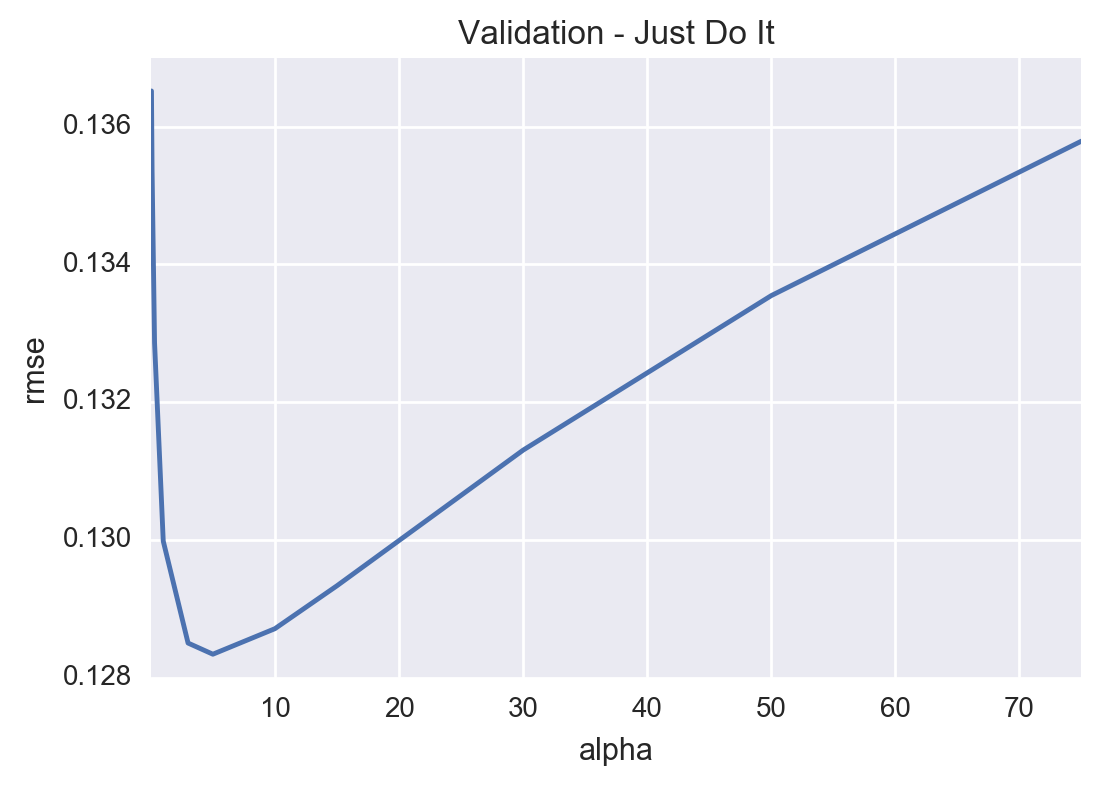

In [17]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha),X_train,y).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [18]:
forest = RandomForestRegressor(n_estimators=100)
scores= cross_val_score(forest,X_train,y,cv=10,scoring = rmse_cv) 

In [19]:
scores

array([ 0.18374134,  0.16418746,  0.19370664,  0.22124844,  0.20790715,
        0.16354545,  0.17260035,  0.1774253 ,  0.19366967,  0.19928235])